In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sympy as sym
from scipy.stats import chi2
import scipy.optimize as spo

import os
import os.path as path
import wget

**(a)** Descargar los datos expermientales de cada canal de observación.

In [186]:
if not path.exists('Data'):
    os.mkdir('Data')

file = 'Data/DataRotacion.csv'

url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/DataRotacion.csv'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

**(b)** Cargue los datos usando Pandas y haga un filtrado para obtener los datos correspondientes a $\lambda = 30$.

In [187]:
Data = pd.read_csv(Path_)
filtro = Data["angle"] == 30
resultado = Data[filtro]
resultado

,h,angle,y,sigmay
20,10.0,30.0,0.0013,0.0015
21,20.0,30.0,0.0017,0.0015
22,30.0,30.0,0.0038,0.0015
23,40.0,30.0,0.0059,0.0015
24,50.0,30.0,0.0067,0.0015
25,60.0,30.0,0.0094,0.0015
26,70.0,30.0,0.0122,0.0015
27,80.0,30.0,0.0132,0.0015
28,90.0,30.0,0.0151,0.0015
29,100.0,30.0,0.0186,0.0015


**(c)** Defina el modelo físico presentado para la desviación por efecto coriolis. El modelo debe tener como entrada la altura inicial de caída $h$, el parámetro de ajuste $p=\omega$, la latitud $\lambda$ y la aceleración de la gravedad $g$.

**(d)** Defina $\chi^2$, donde los argumentos son $(h,y,\text{sigmay},\text{angle},g)$.

**(e)** Minimice usando optimize. Para $\lambda = 30$, debería obtener $\omega = 7.24\times 10^{-5}$.

In [188]:
y_ = np.array(resultado["y"])
h_ =  np.array(resultado["h"])
sigmay_ = np.array(resultado["sigmay"])

def GetModel(h,lamb,p,g=9.81):
    y = 2*np.sqrt(2)*(1/3)*p*np.cos(np.deg2rad(lamb))*np.sqrt(h**3/g)
    return y

def Chi2(p,h,y,sigmay,g=9.81,angle=30):
    return np.sum((y - GetModel(h,angle,p,g))**2/(2*sigmay**2))

p = np.ones(1)

nll = lambda *p: Chi2(*p)
result = spo.minimize(nll,p, args=(h_,y_,sigmay_),options={'disp':True})

Optimization terminated successfully.
         Current function value: 1.145718
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4


**(f)** Dibuje los datos y el modelo para esa latitud.

In [189]:
#Obtención de omega
omega = result.x
omega

array([7.24399804e-05])

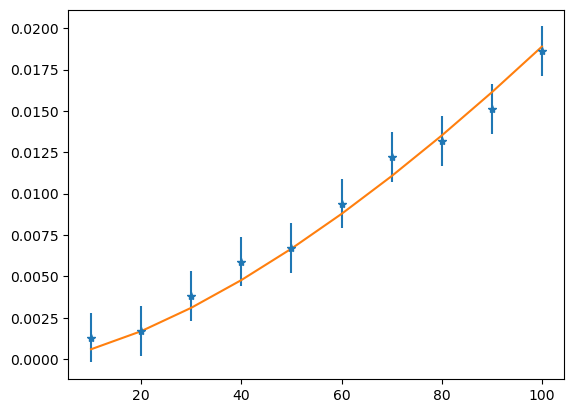

In [190]:
Model = GetModel(h_,30,omega)
plt.errorbar(h_,y_,sigmay_,fmt="*")
plt.plot(h_,Model)

**Propagación de la incertidumbre de la aceleración de la gravedad**

**(a)** Hacer un for loop $N = 300$ para realizar el remuestreo del valor de la gravedad de los puntos experimentales.

**(b)** Genere un valor de gravedad siguiendo la distribución normal $g \sim \mathcal{N}(9.81,1)$.

**(c)** Guarde ese valor en un array llamado Gravedad.

**(d)** Cambie el valor de los puntos experimentales siguiendo la distribución normal $y \sim \mathcal{N}(y, \sigma(y))$ (modificación de bootstrapping):

**(e)** Realice la optimización y guarde el valor de la estimación de la rapidez $\omega$ en otro array, Omega

In [223]:
Gravedad = np.zeros(300)
p_ = np.ones(1)
nll_ = lambda *p_: Chi2(*p_)
Omega = np.zeros(300)

for i in range(300): 
    Gravedad[i] = 9.81 + np.random.normal(loc=0,scale=1)
    y_modified = y_ + np.random.normal( loc=0, scale=sigmay_[0], size=len(y_) )
    result_ = spo.minimize(nll_,p_, args=(h_,y_modified,sigmay_,Gravedad[i]))
    Omega[i] = result_.x
Omega, Gravedad

(array([7.05354315e-05, 8.09498417e-05, 7.38639122e-05, 7.68373396e-05,
        7.07734315e-05, 6.88237942e-05, 7.53100933e-05, 6.94722212e-05,
        7.01971597e-05, 7.69601144e-05, 7.16733441e-05, 7.44503068e-05,
        7.19017377e-05, 7.27280255e-05, 8.13486563e-05, 7.70504403e-05,
        7.44236069e-05, 7.19838032e-05, 7.55629298e-05, 7.35957374e-05,
        6.92158924e-05, 7.24088455e-05, 6.32553306e-05, 7.03440963e-05,
        6.72722935e-05, 7.52730217e-05, 6.69256013e-05, 8.25649641e-05,
        6.35335811e-05, 6.69648316e-05, 6.86370001e-05, 7.88037705e-05,
        7.32426258e-05, 6.61506266e-05, 6.78614283e-05, 7.41759500e-05,
        7.78884409e-05, 6.66333182e-05, 7.08650901e-05, 7.20851886e-05,
        7.38426253e-05, 6.90570665e-05, 7.87225520e-05, 6.82741416e-05,
        7.39469781e-05, 6.69083175e-05, 7.19919706e-05, 7.52014498e-05,
        6.90184289e-05, 7.58557385e-05, 7.61561789e-05, 7.48211973e-05,
        7.50923286e-05, 8.24974322e-05, 7.00335532e-05, 7.582795

**(f)** Genere la distribución conjunta $f(\omega, g)$. Elija bien el tamaño de caja (cuente los
cuadros en la figura por ejemplo).

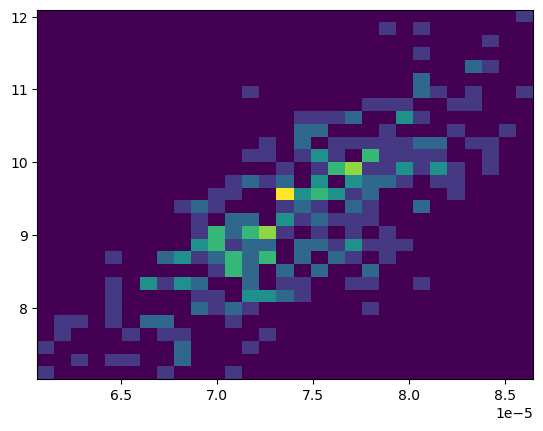

In [224]:
gridy = np.linspace(min(Gravedad),max(Gravedad),30)
gridx = np.linspace(min(Omega),max(Omega),30)

H2, binsx, binsy = np.histogram2d(Omega,Gravedad,bins=(gridx,gridy))
plt.imshow(H2,interpolation='nearest', origin='lower',
        extent=[binsx[0],binsx[-1] , binsy[0], binsy[-1]],aspect="auto")
plt.show()

**(g)** ¿Están las variables relacionadas?

In [232]:
Mean_g = np.sum(Gravedad)/300
Mean_omega = np.sum(Omega)/300

Var_g = ((Gravedad - Mean_g)**2).sum()/300
Var_omega = ((Omega - Mean_omega)**2).sum()/300

Covar_gw = ((Gravedad - Mean_g)*(Omega - Mean_omega)).sum()/300

r = Covar_gw/((np.sqrt(Var_g))*(np.sqrt(Var_omega)))
r

0.7442929160400197

Teniendo el cuenta el coeficiente de correlación $r$ que obtenido anteriormente, se puede observar que éste es bastante próximo a 1, indicando que las variables presentan una relación significativamente fuerte.

**(h)** Marginalice $f(\omega,g)$ para encontrar la distribución $h(\omega)$.

In [234]:
H1 = np.sum(H2,axis=1)
H1

array([ 3.,  5.,  4.,  5.,  8.,  8., 12., 17., 13., 25., 23., 20., 14.,
       13., 22., 19., 22., 16., 14.,  7.,  9.,  5.,  6.,  2.,  3.,  1.,
        1.,  2.,  1.])

**(i)** Usando $h(\omega)$ obtenga el mejor estimador $\omega$ y el intervalo de confianza a un sigma de desviación. En este caso, use los percentiles para histogramas.

In [237]:
cs = np.cumsum(H1)
ij = np.searchsorted(cs,np.percentile(cs,16))
ii = np.searchsorted(cs,np.percentile(cs,50))
ji = np.searchsorted(cs,np.percentile(cs,84))

array([  3.,   8.,  12.,  17.,  25.,  33.,  45.,  62.,  75., 100., 123.,
       143., 157., 170., 192., 211., 233., 249., 263., 270., 279., 284.,
       290., 292., 295., 296., 297., 299., 300.])